<p align="center">
  <img src="https://i.imgur.com/FnerTD8.jpeg" width="600" height="400">
</p>

# <h1><center>Exploring and Monitoring Solar Power Systems: An Interactive Approach<center><h1>


# Contents Overview
* [1. Overview](#section-one)
* [2. Data Preparation](#section-two)
* [3. Investigating the Data](#section-three)
* [4. Monitoring System Health](#section-four)
* [5. Final Thoughts](#section-five)


<a id="section-one"></a>
# 1. Introduction & Key Ideas

This notebook focuses on data analysis, condition monitoring, and fault detection for solar power plants using various techniques including Machine Learing.

## 1.1 Dataset Description

The dataset includes information from two solar power plants in India, collected over 34 days:
- Power generation data (measured at inverters)
- Weather data (measured with a single line of sensors at the plant)

## 1.2 Objectives

1. **Faulty or suboptimal equipment identification**
2. **Panel cleaning/maintenance identification**




<a id="section-two"></a>
# 2. Data & Libraries Import
We will initially examine the data for Plant 1 (both power generation and weather). Plant 2's data can be explored similarly later on. 


In [3]:
import os
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.dates as mdates 
xformatter = mdates.DateFormatter('%H:%M') # for time axis plots

In [4]:
# Import all available data 
df_plant_gen1 = pd.read_csv("/content/Plant_1_Generation_Data.csv")
df_plant_gen2 = pd.read_csv("/content/Plant_2_Generation_Data.csv")

df_plant_weather1 = pd.read_csv("/content/Plant_1_Weather_Sensor_Data.csv")
df_plant_weather2 = pd.read_csv("/content/Plant_2_Weather_Sensor_Data.csv")

## 2.1 Identifying Issues with the dataset using EDA


### 2.1.1 Column Descriptions

In [5]:
df_plant_gen1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29767 entries, 0 to 29766
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    29767 non-null  object 
 1   PLANT_ID     29767 non-null  int64  
 2   SOURCE_KEY   29767 non-null  object 
 3   DC_POWER     29766 non-null  float64
 4   AC_POWER     29766 non-null  float64
 5   DAILY_YIELD  29766 non-null  float64
 6   TOTAL_YIELD  29766 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 1.6+ MB


**Plant_1_Generation_Data: Column descriptions**
- **DATE_TIME:** Date and time of each observation, recorded at 15-minute intervals.
- **PLANT_ID:** A common identifier for the entire file.
- **SOURCE_KEY:** Represents the inverter ID in this file.
- **DC_POWER:** DC power generated by the inverter (source_key) during each 15-minute interval. Units - kW.
- **AC_POWER:** AC power generated by the inverter (source_key) during each 15-minute interval. Units - kW.
- **TOTAL_YIELD:** Cumulative yield for the inverter up to that point in time.


In [6]:
df_plant_weather1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_TIME            3182 non-null   object 
 1   PLANT_ID             3182 non-null   int64  
 2   SOURCE_KEY           3182 non-null   object 
 3   AMBIENT_TEMPERATURE  3182 non-null   float64
 4   MODULE_TEMPERATURE   3182 non-null   float64
 5   IRRADIATION          3182 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 149.3+ KB


**Plant_2_Generation_Data: Column descriptions**
- **DATE_TIME:** Date and time of each observation, recorded at 15-minute intervals.
- **PLANT_ID:** A common identifier for the entire file.
- **SOURCE_KEY:** Represents the sensor panel ID, which is the same for the entire file since there's only one sensor panel for the plant.
- **AMBIENT_TEMPERATURE:** Ambient temperature at the plant. *Note: Assumed unit is $°C$ .
- **MODULE_TEMPERATURE:** Temperature reading for the module (solar panel) attached to the sensor panel. *Note: Assumed unit is $°C$ .*
- **IRRADATION:** Irradiation amount for each 15-minute interval. *Note: Assumed unit is $kW/m^2$ .


### 2.1.2 Check for Missing data

In [7]:
# Check missing values in df_plant_gen1
df_plant_gen1.isnull().sum().sort_values(ascending=False)


DC_POWER       1
AC_POWER       1
DAILY_YIELD    1
TOTAL_YIELD    1
DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
dtype: int64

In [8]:
# Check missing values in df_plant_weather1
df_plant_weather1.isnull().sum().sort_values(ascending=False)

DATE_TIME              0
PLANT_ID               0
SOURCE_KEY             0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64

### 2.1.3 No. of inverters in the database and no. of measurements

In [9]:
df_plant_gen1.SOURCE_KEY.value_counts()

bvBOhCH3iADSZry    1374
1BY6WEcLGh8j5v7    1373
7JYdWkrLSPkdwr4    1359
VHMLBKoKgIrUVDU    1359
ZnxXDlPa8U1GXgE    1356
ih0vzX44oOqAx2f    1356
iCRJl6heRkivqQ3    1354
McdE0feGgRqW7Ca    1353
pkci93gMrogZuBj    1353
uHbuxQJl8lW7ozc    1353
wCURE6d3bPkepu2    1353
z9Y9gH1T5YWrNuG    1353
zBIq5rxdHJRwDNY    1353
ZoEaEvLYb1n2sOq    1352
rGa61gmuvPhdLxV    1352
sjndEbLyjtCKgGv    1352
zVJPv84UY57bAof    1352
WRmjgnKYAwPKWDb    1344
adLQvlD726eNBSB    1344
1IF53ai7Xc0U56Y    1344
3PZuoBAID5Wc2HD    1344
YxYtjZvoooNbGkE    1333
pkci93gMrogZuB        1
Name: SOURCE_KEY, dtype: int64

In [10]:
print('There are {} different inverters. Number of measurements per inverter range from {} to {}.' .format(df_plant_gen1.SOURCE_KEY.nunique(),df_plant_gen1.SOURCE_KEY.value_counts().min(), df_plant_gen1.SOURCE_KEY.value_counts().max() ))

There are 23 different inverters. Number of measurements per inverter range from 1 to 1374.


## 2.2 Dataset Preprocessing and Merging

To merge the datasets, we will follow these steps:

1. Modify the DATE_TIME formats.
2. Eliminate redundant columns.
3. Merge the datasets based on DATE_TIME.
4. Introduce separate columns for date and time.
5. Label our inverters from 1 to 22.


In [11]:
# Modify the DATE_TIME formats.
df_plant_gen1['DATE_TIME'] = pd.to_datetime(df_plant_gen1['DATE_TIME'],format = '%d-%m-%Y %H:%M')
df_plant_weather1['DATE_TIME'] = pd.to_datetime(df_plant_weather1['DATE_TIME'],format = '%Y-%m-%d %H:%M:%S')


In [12]:
# Eliminate redundant columns and Merge the datasets based on DATE_TIME.
df_plant1 = pd.merge(df_plant_gen1.drop(columns = ['PLANT_ID']), df_plant_weather1.drop(columns = ['PLANT_ID', 'SOURCE_KEY']), on='DATE_TIME')

In [13]:

# add inverter number column to dataframe
sensorkeys = df_plant1.SOURCE_KEY.unique().tolist() # unique sensor keys
sensornumbers = list(range(1,len(sensorkeys)+1)) # sensor number
dict_sensor = dict(zip(sensorkeys, sensornumbers)) # dictionary of sensor numbers and corresponding keys

# add column
df_plant1['SENSOR_NUM'] = 0
for i in range(df_plant_gen1.shape[0]):
    df_plant1['SENSOR_NUM'][i] = dict_sensor[df_plant_gen1["SOURCE_KEY"][i]]

# add Sensor Number as string
df_plant1["SENSOR_NAME"] = df_plant1["SENSOR_NUM"].apply(str) # add string column of sensor name

<ipython-input-13-3b49c91d9d1f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plant1['SENSOR_NUM'][i] = dict_sensor[df_plant_gen1["SOURCE_KEY"][i]]


In [14]:
# adding separate time and date columns
df_plant1["DATE"] = pd.to_datetime(df_plant1["DATE_TIME"]).dt.date # add new column with date
df_plant1["TIME"] = pd.to_datetime(df_plant1["DATE_TIME"]).dt.time # add new column with time

# add hours and minutes for ml models
df_plant1['HOURS'] = pd.to_datetime(df_plant1['TIME'],format='%H:%M:%S').dt.hour
df_plant1['MINUTES'] = pd.to_datetime(df_plant1['TIME'],format='%H:%M:%S').dt.minute
df_plant1['MINUTES_PASS'] = df_plant1['MINUTES'] + df_plant1['HOURS']*60

# add date as string column
df_plant1["DATE_STR"] = df_plant1["DATE"].astype(str) # add column with date as string

In [15]:
df_plant1.head()

DATE_TIME       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0 2020-05-15  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6259559.0   
1 2020-05-15  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6183645.0   
2 2020-05-15  3PZuoBAID5Wc2HD       0.0       0.0          0.0    6987759.0   
3 2020-05-15  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7602960.0   
4 2020-05-15  McdE0feGgRqW7Ca       0.0       0.0          0.0    7158964.0   

   AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  SENSOR_NUM  \
0            25.184316           22.857507          0.0           1   
1            25.184316           22.857507          0.0           2   
2            25.184316           22.857507          0.0           3   
3            25.184316           22.857507          0.0           4   
4            25.184316           22.857507          0.0           5   

  SENSOR_NAME        DATE      TIME  HOURS  MINUTES  MINUTES_PASS    DATE_STR  
0           1  2020-05-15  00:00:00      0        0             0  2020-05-15  
1           2  2020-05-15  00:00:00      0        0             0  2020-05-15  
2           3  2020-05-15  00:00:00      0        0             0  2020-05-15  
3           4  2020-05-15  00:00:00      0        0             0  2020-05-15  
4           5  2020-05-15  00:00:00      0        0             0  2020-05-15

<a id="section-three"></a>
# 3. Data Exploration & Failure Detection

Now that we have a merged dataset we can take a closer look at data distributions and correlations.

## 3.1 Correlation Analysis

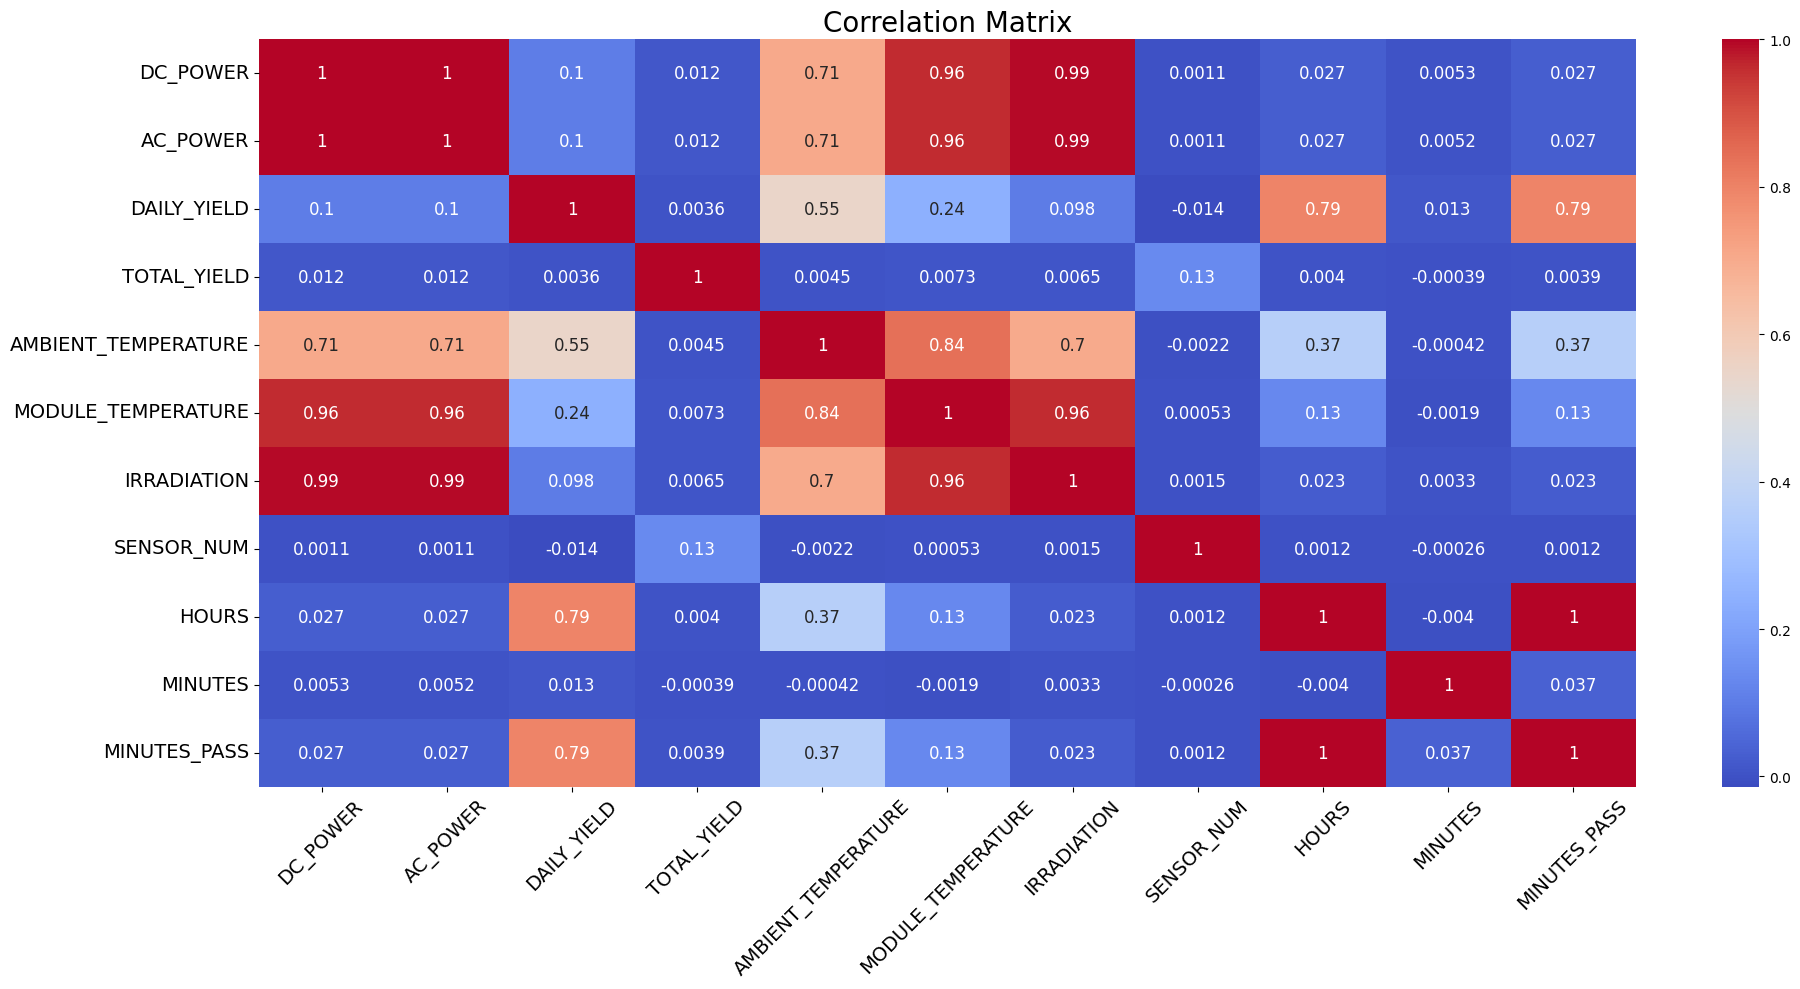

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

cols_corr = ["DC_POWER", "AC_POWER", "DAILY_YIELD", "TOTAL_YIELD", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION", "SENSOR_NUM", "HOURS", "MINUTES", "MINUTES_PASS"]
corrMatrix = df_plant1[cols_corr].corr()

# Increase the figure size for better readability
plt.figure(figsize=(20, 10))

# Use a clearer color map and adjust the font size
fig_corr = sns.heatmap(corrMatrix, cmap="coolwarm", annot=True, annot_kws={"size": 12})

# Customize the plot appearance
plt.title('Correlation Matrix', fontsize=20)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()


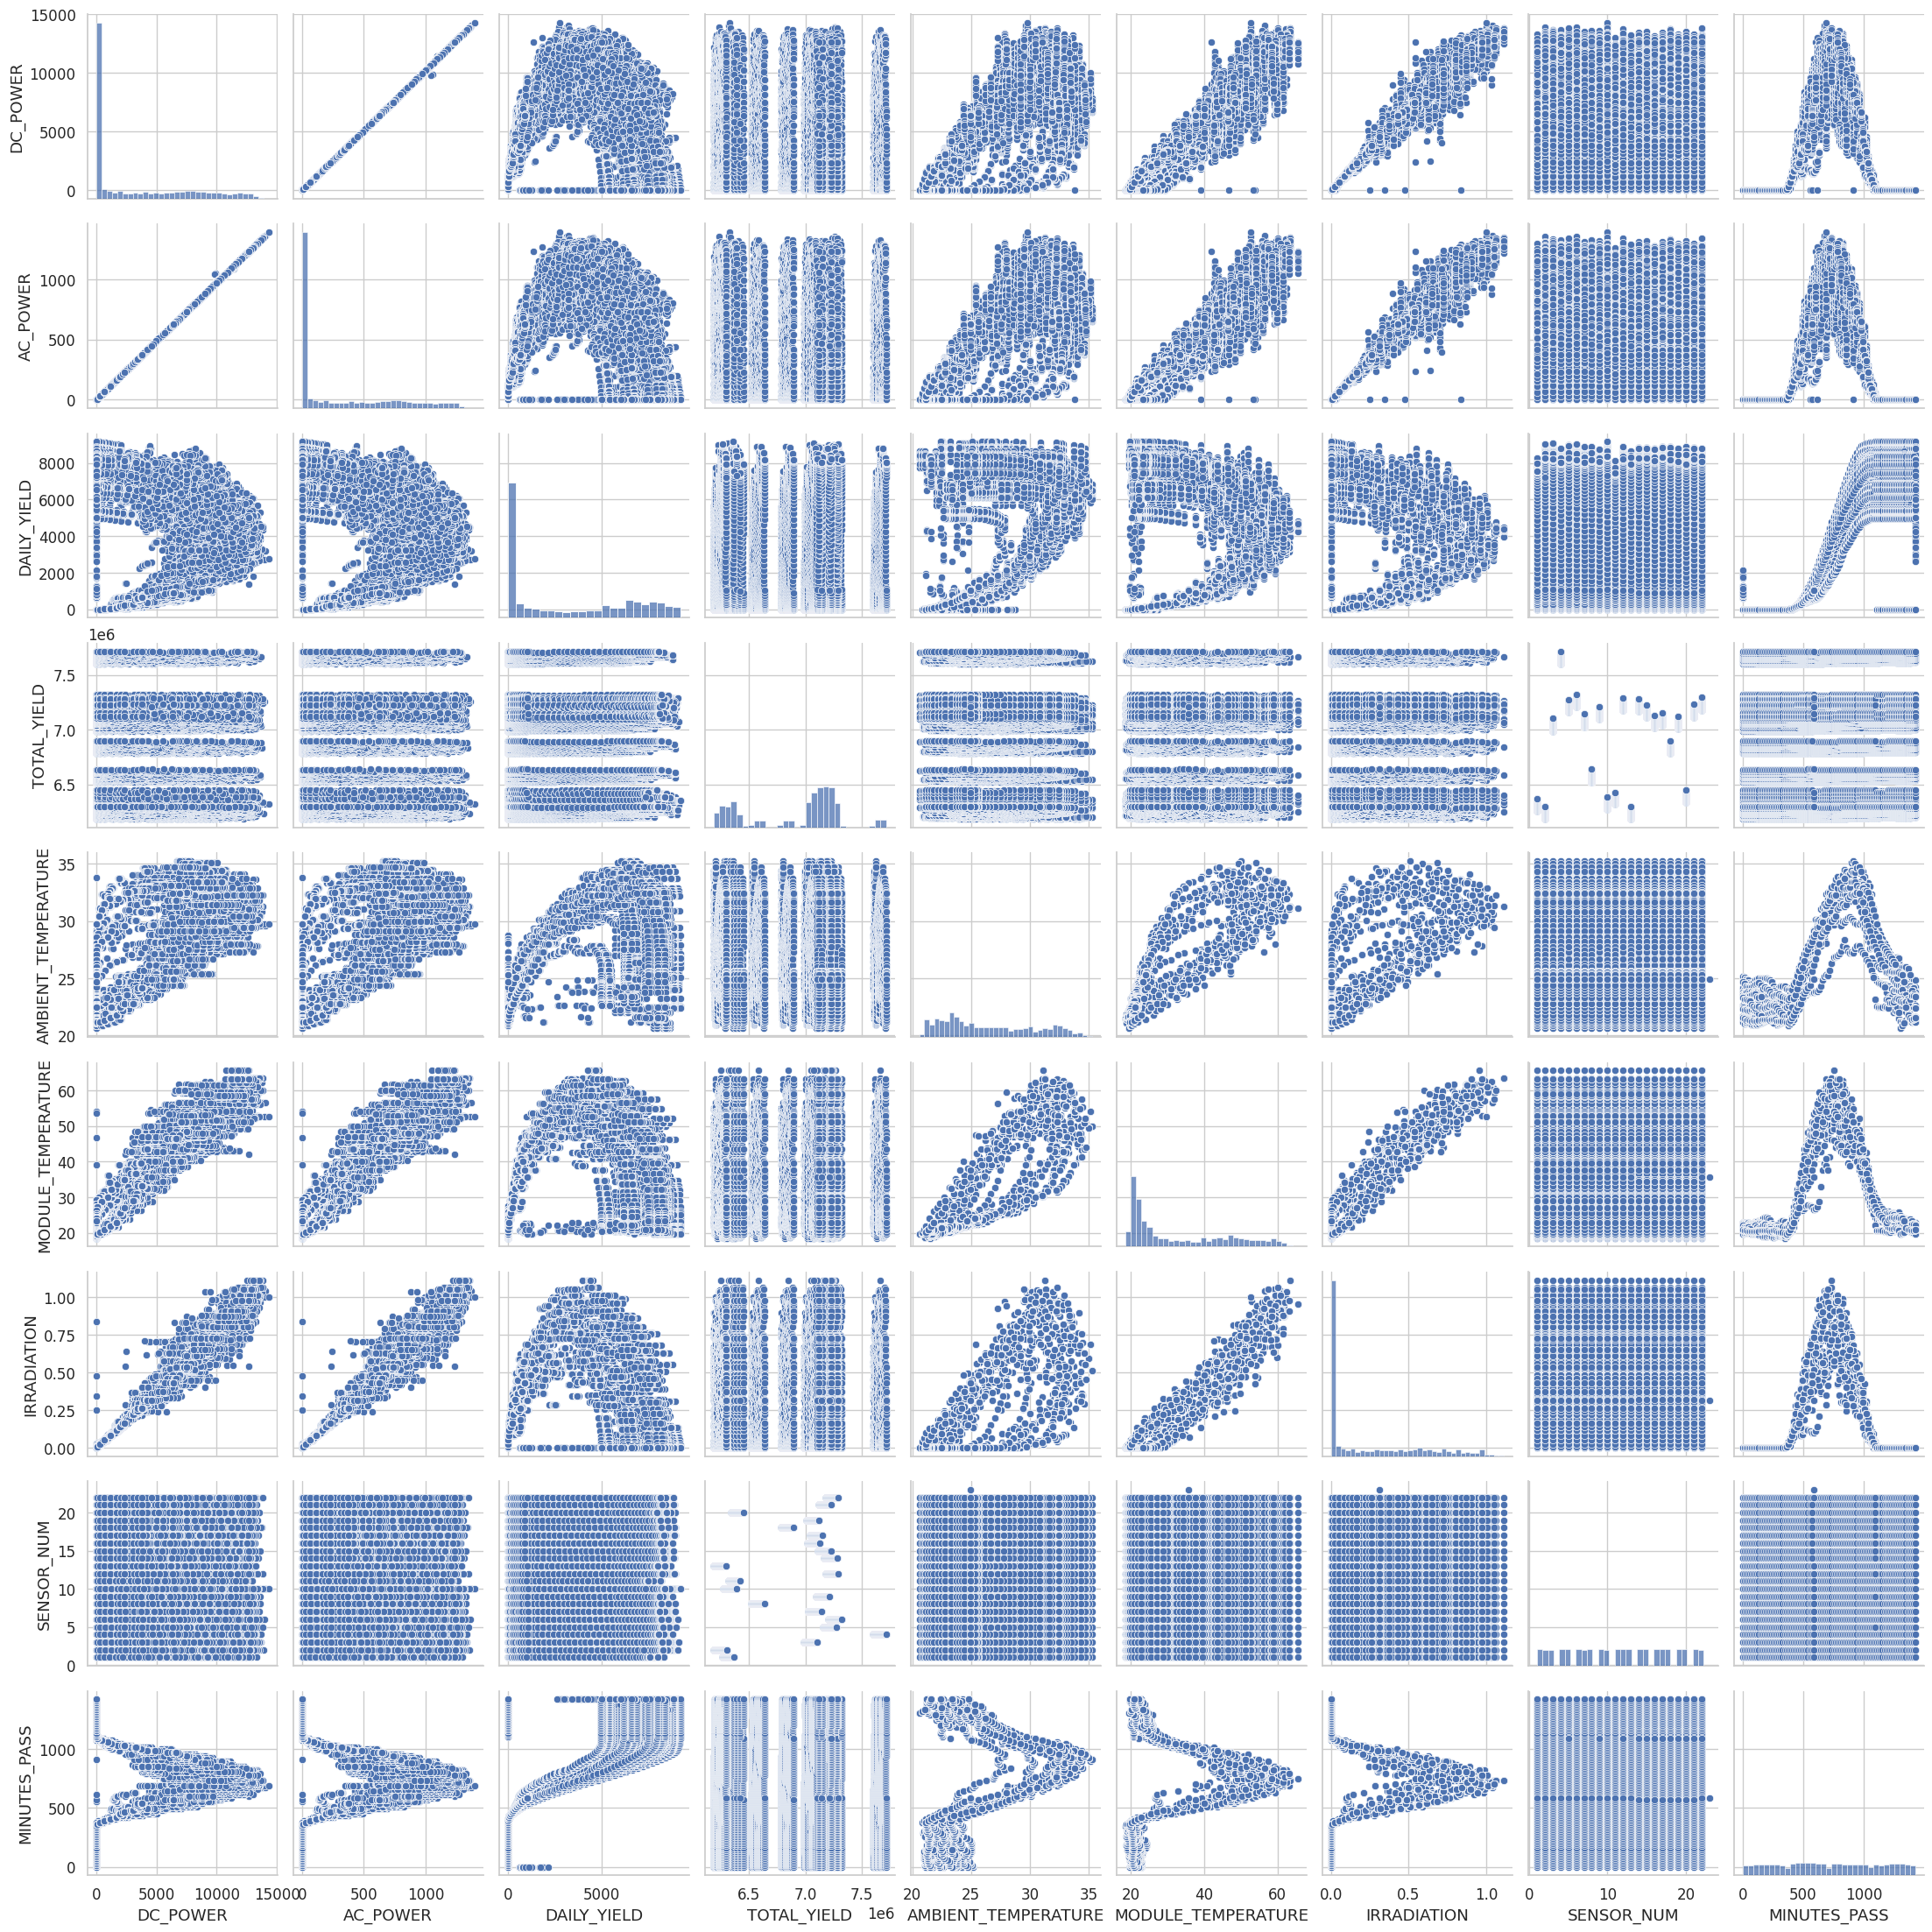

In [17]:

sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [15, 5]})
cols_pair = ["DC_POWER", "AC_POWER", "DAILY_YIELD", "TOTAL_YIELD", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION", "SENSOR_NUM", "MINUTES_PASS"]
fig_pair = sns.pairplot(df_plant1[cols_pair])
plt.show()

### Key Insights
- High correlation between:
    - DC Power and AC Power
    - Irradiation and DC Power
    - Module Temperature and DC Power
    
- Outlier detected:
    - DC Power v/s AC Power
    - Irradiation v/s DC Power

- Outliers' implications:
    - DC-AC conversion: Inverter malfunction (If there is DC power delivered but less AC power generated than expected the inverter may be malfunctioning.)
    - Power-Irradiation: Panel line failure (If there is enough sunlight but no power is generated, this points to faulty photovoltaic cells.)




Let's look a bit more closer at the pairplots where we identified outliers and see if these are spread out evenly across all inverters or if we can identify specific inverters.

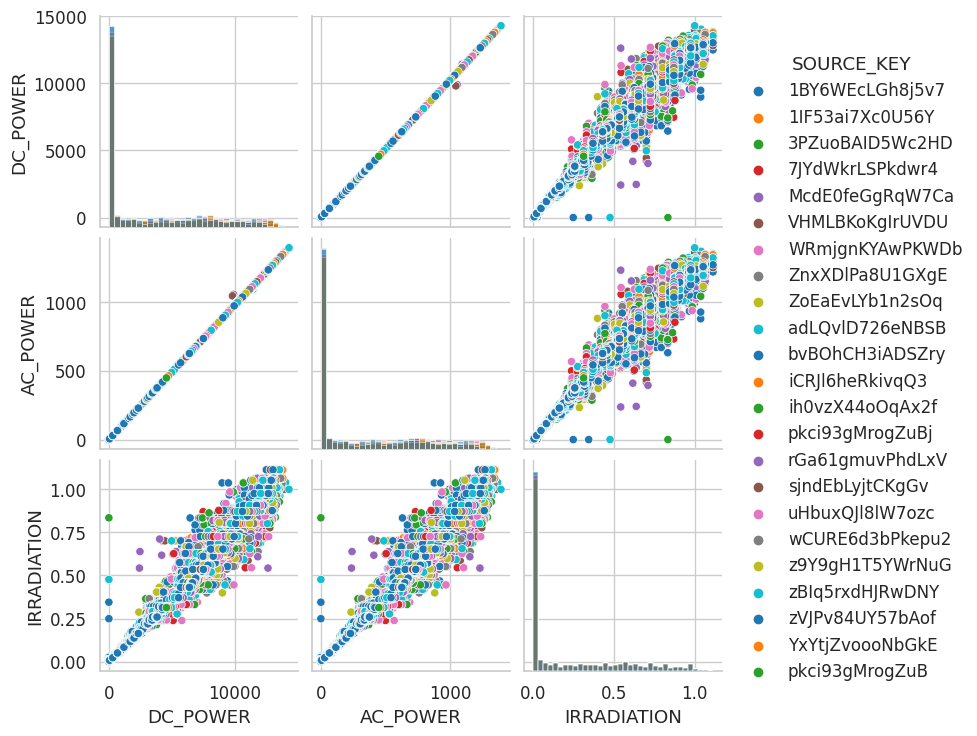

In [18]:
cols_out = ["DC_POWER", "AC_POWER", "IRRADIATION", "SOURCE_KEY"]
sns.pairplot(df_plant1[cols_out], hue="SOURCE_KEY", diag_kind="hist", palette="tab10")
plt.show()

Most of the outliers seem to come from a small group of inverters!

## 3.2 DC Power v/s AC Power

This shows the effectiveness of our inverter in transforming DC power into AC power. Any anomalies during this power conversion process can be utilized to identify defective inverters

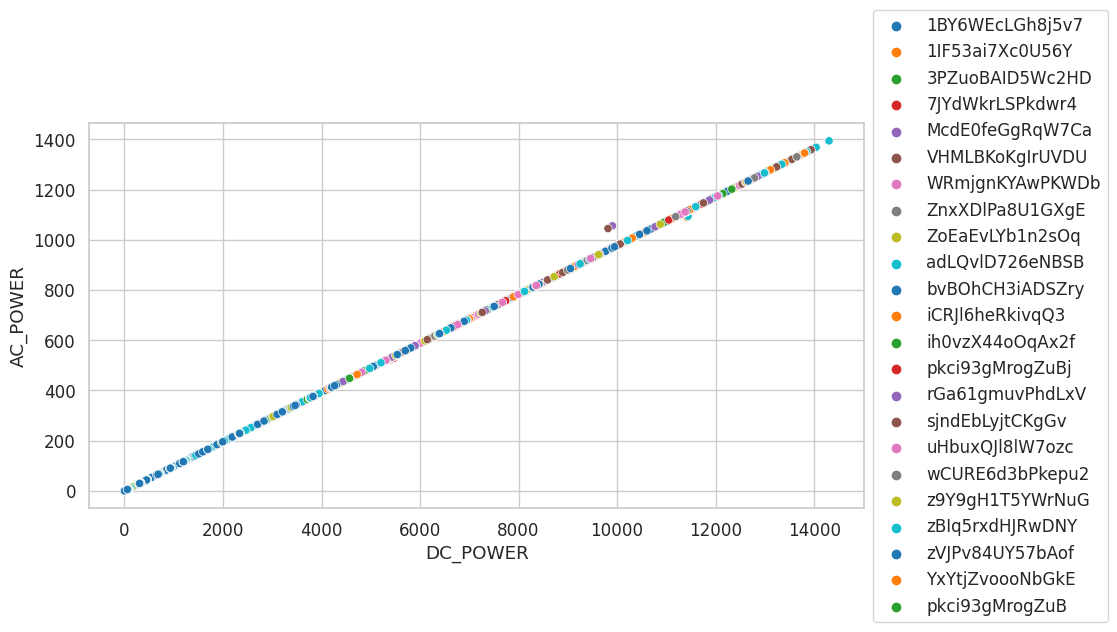

In [19]:
plt.figure(figsize=(10,5))
fig_power = sns.scatterplot(data=df_plant1, x="DC_POWER", y="AC_POWER", hue="SOURCE_KEY", palette="tab10")
fig_power.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.show()

Outlier SOURCE_KEYs:
['1BY6WEcLGh8j5v7' '1IF53ai7Xc0U56Y' '3PZuoBAID5Wc2HD' '7JYdWkrLSPkdwr4'
 'McdE0feGgRqW7Ca' 'WRmjgnKYAwPKWDb' 'ZoEaEvLYb1n2sOq' 'adLQvlD726eNBSB'
 'bvBOhCH3iADSZry' 'iCRJl6heRkivqQ3' 'ih0vzX44oOqAx2f' 'pkci93gMrogZuBj'
 'rGa61gmuvPhdLxV' 'sjndEbLyjtCKgGv' 'uHbuxQJl8lW7ozc' 'wCURE6d3bPkepu2'
 'z9Y9gH1T5YWrNuG' 'zBIq5rxdHJRwDNY' 'zVJPv84UY57bAof' 'VHMLBKoKgIrUVDU'
 'ZnxXDlPa8U1GXgE' 'YxYtjZvoooNbGkE']


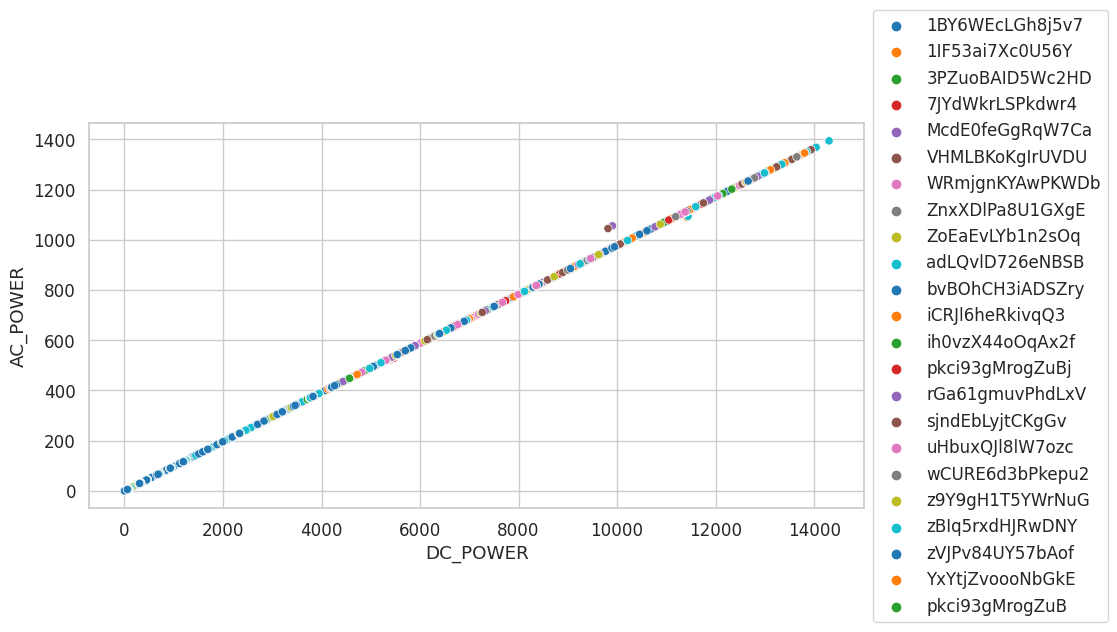

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_plant1 is the data frame containing the data

# Calculate the ratio between AC_POWER and DC_POWER
df_plant1['POWER_RATIO'] = df_plant1['AC_POWER'] / df_plant1['DC_POWER']

# Calculate the mean and standard deviation of the POWER_RATIO
mean_ratio = np.mean(df_plant1['POWER_RATIO'])
std_ratio = np.std(df_plant1['POWER_RATIO'])

# Set a threshold for identifying outliers (e.g., points beyond 2 standard deviations from the mean)
threshold = 2 * std_ratio

# Find the outliers
outliers = df_plant1[(df_plant1['POWER_RATIO'] < mean_ratio - threshold) | (df_plant1['POWER_RATIO'] > mean_ratio + threshold)]

# Print the 'SOURCE_KEY' of the outliers
print("Outlier SOURCE_KEYs:")
print(outliers['SOURCE_KEY'].unique())

# Plot the scatterplot
plt.figure(figsize=(10, 5))
fig_power = sns.scatterplot(data=df_plant1, x="DC_POWER", y="AC_POWER", hue="SOURCE_KEY", palette="tab10")
fig_power.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.show()


In [21]:
mean_ratio = np.mean(df_plant1['POWER_RATIO'])
std_ratio = np.std(df_plant1['POWER_RATIO'])
threshold = 2

df_plant1['Z_SCORE'] = (df_plant1['POWER_RATIO'] - mean_ratio) / std_ratio
outliers_z_score = df_plant1[(df_plant1['Z_SCORE'] < -threshold) | (df_plant1['Z_SCORE'] > threshold)]


In [22]:
outliers_z_score

DATE_TIME       SOURCE_KEY    DC_POWER   AC_POWER  \
510   2020-05-15 06:00:00  1BY6WEcLGh8j5v7   37.142857   3.585714   
511   2020-05-15 06:00:00  1IF53ai7Xc0U56Y   53.500000   5.162500   
512   2020-05-15 06:00:00  3PZuoBAID5Wc2HD   58.000000   5.585714   
513   2020-05-15 06:00:00  7JYdWkrLSPkdwr4   58.428571   5.628571   
514   2020-05-15 06:00:00  McdE0feGgRqW7Ca   54.375000   5.250000   
...                   ...              ...         ...        ...   
29461 2020-05-30 06:15:00  uHbuxQJl8lW7ozc  330.375000  31.912500   
29462 2020-05-30 06:15:00  wCURE6d3bPkepu2  313.571429  30.300000   
29463 2020-05-30 06:15:00  z9Y9gH1T5YWrNuG  313.285714  30.257143   
29464 2020-05-30 06:15:00  zBIq5rxdHJRwDNY  312.857143  30.214286   
29465 2020-05-30 06:15:00  zVJPv84UY57bAof  306.125000  29.587500   

       DAILY_YIELD  TOTAL_YIELD  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  \
510       0.000000  6259559.000            24.088446           22.206757   
511       0.000000  6183645.000            24.088446           22.206757   
512       0.000000  6987759.000            24.088446           22.206757   
513       0.000000  7602960.000            24.088446           22.206757   
514       0.000000  7158964.000            24.088446           22.206757   
...            ...          ...                  ...                 ...   
29461     4.000000  7151936.000            21.185370           20.100395   
29462     4.000000  6895884.000            21.185370           20.100395   
29463     4.000000  7120459.000            21.185370           20.100395   
29464     3.857143  6449908.857            21.185370           20.100395   
29465     3.500000  7228690.500            21.185370           20.100395   

       IRRADIATION  SENSOR_NUM SENSOR_NAME        DATE      TIME  HOURS  \
510       0.005887           1           1  2020-05-15  06:00:00      6   
511       0.005887           2           2  2020-05-15  06:00:00      6   
512       0.005887           3           3  2020-05-15  06:00:00      6   
513       0.005887           4           4  2020-05-15  06:00:00      6   
514       0.005887           5           5  2020-05-15  06:00:00      6   
...            ...         ...         ...         ...       ...    ...   
29461     0.023007          17          17  2020-05-30  06:15:00      6   
29462     0.023007          18          18  2020-05-30  06:15:00      6   
29463     0.023007          19          19  2020-05-30  06:15:00      6   
29464     0.023007          20          20  2020-05-30  06:15:00      6   
29465     0.023007          21          21  2020-05-30  06:15:00      6   

       MINUTES  MINUTES_PASS    DATE_STR  POWER_RATIO   Z_SCORE  
510          0           360  2020-05-15     0.096538 -2.592116  
511          0           360  2020-05-15     0.096495 -2.687314  
512          0           360  2020-05-15     0.096305 -3.106443  
513          0           360  2020-05-15     0.096333 -3.046634  
514          0           360  2020-05-15     0.096552 -2.562846  
...        ...           ...         ...          ...       ...  
29461       15           375  2020-05-30     0.096595 -2.467824  
29462       15           375  2020-05-30     0.096629 -2.392956  
29463       15           375  2020-05-30     0.096580 -2.500380  
29464       15           375  2020-05-30     0.096575 -2.510720  
29465       15           375  2020-05-30     0.096652 -2.342210  

[1314 rows x 19 columns]

## 3.3 Irradiation vs DC-Power
This demonstrates the efficiency of our photovoltaic panel production in converting sunlight into DC power. Any deviations in this conversion process may signify faulty photovoltaic panel lines

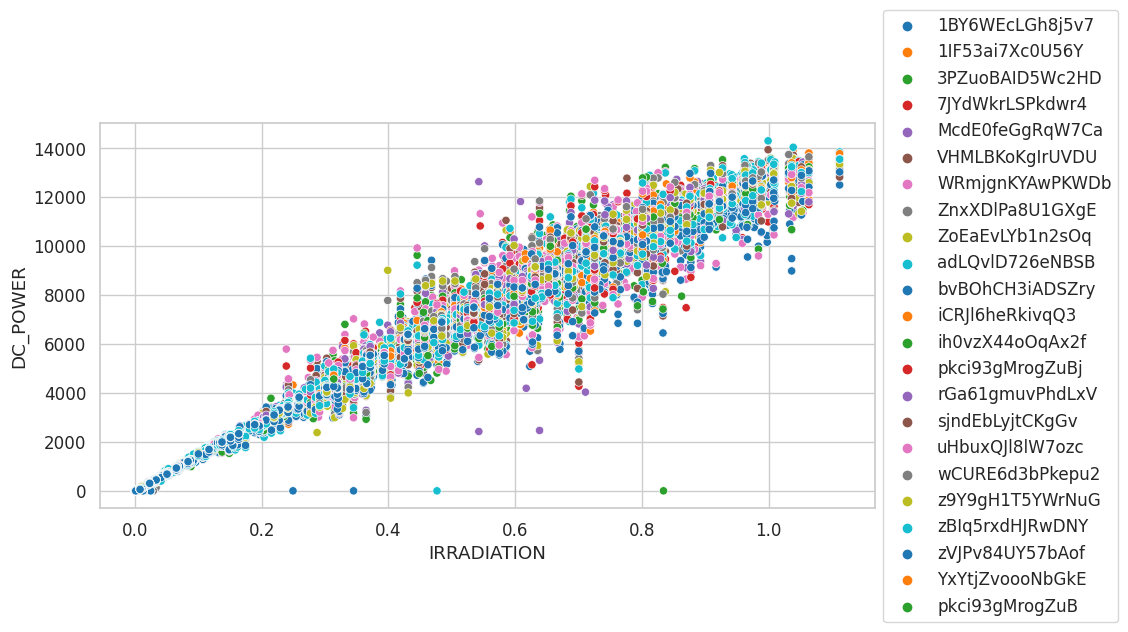

In [23]:
plt.figure(figsize=(10,5))
fig_irr = sns.scatterplot(data=df_plant1, x="IRRADIATION", y="DC_POWER", hue="SOURCE_KEY", palette="tab10")
fig_irr.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.show()

* From our data, it is evident that certain inverters did not receive any DC power despite ample sunlight for power generation. 
* This indicates equipment malfunction in our system. To demonstrate this, we can closely examine the daily distribution of the produced power and the measured irradiation

## 3.4 Time v/s DC-Power

In [24]:
fig = px.scatter(df_plant1, x="TIME", y="DC_POWER", title="DC Power: Daily Distribution", color = "DATE_STR")
fig.update_traces(marker=dict(size=5, opacity=0.7), selector=dict(mode='markers'))
fig.show()

* The first figure shows multiple occasions where there was no power generated during daytime.

## 3.5 Time v/s Irradiation

In [25]:
fig = px.scatter(df_plant1, x="TIME", y="IRRADIATION", title="Irradiation: Daily Distribution", color = "DATE_STR")
fig.update_traces(marker=dict(size=5, opacity=0.7), selector=dict(mode='markers'))
fig.show()

* The second figure shows that the irradiation level never dropped low enough during the day to explain this loss of power. This indicates equipment failure!



<a id="section-four"></a>
# 4. Condition Monitoring

In section 3 we found evidence that point towards equipment failure. Now we are going to build models to detect equipment failure automatically.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Load your dataset
# df = pd.read_csv('your_data.csv')

# Preprocessing
# Scale the features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_plant1[['DC_POWER', 'AC_POWER']])

# Split the dataset into train and test sets
train_data, test_data = train_test_split(scaled_data, test_size=0.3, shuffle=False, random_state=42)

# Autoencoder Model
input_dim = train_data.shape[1]
encoding_dim = 2

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the autoencoder
history = autoencoder.fit(train_data, train_data,
                          epochs=100,
                          batch_size=32,
                          validation_data=(test_data, test_data),
                          verbose=1)

# Plot loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Calculate reconstruction error
train_data_pred = autoencoder.predict(train_data)
train_mse = np.mean(np.power(train_data - train_data_pred, 2), axis=1)
test_data_pred = autoencoder.predict(test_data)
test_mse = np.mean(np.power(test_data - test_data_pred, 2), axis=1)

# Determine a threshold for anomaly detection
threshold = np.quantile(train_mse, 0.95)  # Adjust the quantile value based on your desired sensitivity
print(f"Anomaly detection threshold: {threshold}")

# Detect anomalies in the test set
anomalies = test_mse > threshold
print("Number of anomalies detected:", np.sum(anomalies))


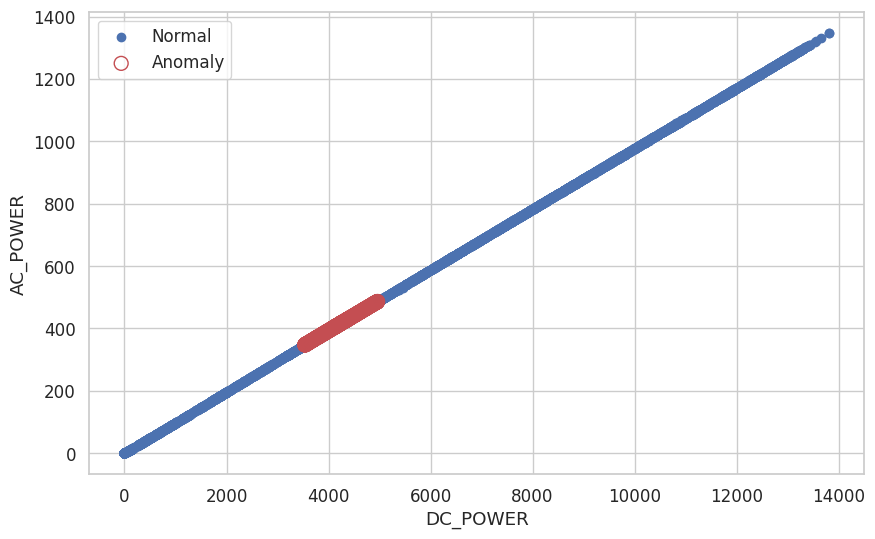

In [27]:
import matplotlib.pyplot as plt

# Get the unscaled test data
test_data_unscaled = scaler.inverse_transform(test_data)

# Create a DataFrame with the test data and anomaly labels
test_df = pd.DataFrame(test_data_unscaled, columns=['DC_POWER', 'AC_POWER'])
test_df['ANOMALY'] = anomalies

# Create a scatter plot of DC_POWER vs AC_POWER
fig, ax = plt.subplots(figsize=(10, 6))
normal_data = test_df[test_df['ANOMALY'] == False]
anomaly_data = test_df[test_df['ANOMALY'] == True]

ax.scatter(normal_data['DC_POWER'], normal_data['AC_POWER'], label='Normal')
ax.scatter(anomaly_data['DC_POWER'], anomaly_data['AC_POWER'], label='Anomaly', marker='o', edgecolors='r', facecolors='none', s=100)

ax.set_xlabel('DC_POWER')
ax.set_ylabel('AC_POWER')
ax.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.optimizers import Adam

# Load your dataset
# df = pd.read_csv('your_data.csv')

# Preprocessing
# Scale the features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_plant1[['DC_POWER', 'AC_POWER']])

# Create a function to reshape the data into sequences for LSTM
def create_sequences(data, seq_length):
    X = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
    return np.array(X)

# Define sequence length and reshape the data
seq_length = 10
sequences = create_sequences(scaled_data, seq_length)

# Split the dataset into train and test sets
train_data, test_data = train_test_split(sequences, test_size=0.3, shuffle=False, random_state=42)

# LSTM Autoencoder Model
input_dim = train_data.shape[2]
timesteps = train_data.shape[1]
latent_dim = 2

inputs = Input(shape=(timesteps, input_dim))
encoded = LSTM(latent_dim)(inputs)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(input_dim, return_sequences=True)(decoded)

autoencoder = Model(inputs=inputs, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the autoencoder
history = autoencoder.fit(train_data, train_data,
                          epochs=25,
                          batch_size=32,
                          validation_data=(test_data, test_data),
                          verbose=1)

# Plot loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Calculate reconstruction error
train_data_pred = autoencoder.predict(train_data)
train_mse = np.mean(np.power(train_data - train_data_pred, 2), axis=(1, 2))
test_data_pred = autoencoder.predict(test_data)
test_mse = np.mean(np.power(test_data - test_data_pred, 2), axis=(1, 2))




In [29]:
# Determine a threshold for anomaly detection
threshold = np.quantile(train_mse, 0.99)  # Adjust the quantile value based on your desired sensitivity
print(f"Anomaly detection threshold: {threshold}")

# Detect anomalies in the test set
anomalies = test_mse > threshold
print("Number of anomalies detected:", np.sum(anomalies))

Anomaly detection threshold: 0.014378164890187223
Number of anomalies detected: 135


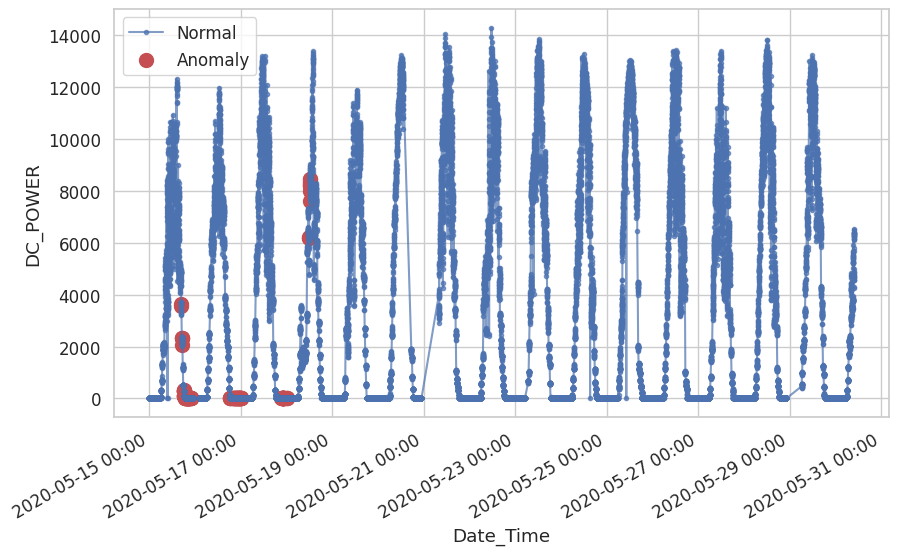

In [30]:
# Calculate the indices of the sequences where anomalies are detected
anomaly_indices = np.where(anomalies)[0] + seq_length

# Create a new column 'ANOMALY' and set all values to False
df_plant1['ANOMALY'] = False

# Update the 'ANOMALY' column using the anomaly_indices
df_plant1.loc[df_plant1.index[anomaly_indices], 'ANOMALY'] = True

# Create a scatter plot of Date_Time vs DC_POWER
fig, ax = plt.subplots(figsize=(10, 6))
normal_data = df_plant1[df_plant1['ANOMALY'] == False]
anomaly_data = df_plant1[df_plant1['ANOMALY'] == True]

ax.plot(normal_data['DATE_TIME'], normal_data['DC_POWER'], label='Normal', linestyle='-', marker='.', alpha=0.7)
ax.scatter(anomaly_data['DATE_TIME'], anomaly_data['DC_POWER'], label='Anomaly', marker='o', color='r', s=100)

ax.set_xlabel('Date_Time')
ax.set_ylabel('DC_POWER')
ax.legend()

# Improve date formatting on the x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
fig.autofmt_xdate()

plt.show()


## 4.1 Rule-based Fault Detection
During the data exploration we found a simple way to identify faulty equipment: If there is no power measured at the inverter during normal daytime operation, we can assume/identify equipment failure. Let's create a new column ("STATUS") that identifies faulty operation:

In [31]:
# Function to check if time is during daytime operation
def time_in_range(start, end, x):
    """Return true if x is in the range [start, end]"""
    if start <= end:
        return start <= x <= end
    else:
        return start <= x or x <= end
    
# set normal daytime operation range
start=datetime.time(6,30,0) # sunrise
end=datetime.time(17,30,0) # sunset

# Create new column to check proper operation
# Return "Normal" if operation is normal and "Fault" if operation is faulty
df_plant1["STATUS"] = 0
for index in df_plant1.index:
    if  time_in_range(start, end, df_plant1["TIME"][index]) and df_plant1["DC_POWER"][index] == 0:
        df_plant1["STATUS"][index] = "Fault"
    else:
        df_plant1["STATUS"][index] = "Normal"

<ipython-input-31-1fb67eb57677>:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [80]:
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

# Function to convert time to seconds
def time_to_seconds(t):
    return (t.hour * 3600) + (t.minute * 60) + t.second

# Function to check if time is during daytime operation in seconds
def time_in_range(start, end, x):
    """Return true if x is in the range [start, end]"""
    if start <= end:
        return start <= x <= end
    else:
        return start <= x or x <= end

# set normal daytime operation range
start = datetime.time(6, 30, 0)  # sunrise
start_time_seconds = time_to_seconds(start)

end = datetime.time(17, 30, 0)  # sunset
end_time_seconds = time_to_seconds(end)

# Load your data into the DataFrame df_plant1

# Convert time to seconds
df_plant1['TIME_SECONDS'] = df_plant1['TIME'].apply(time_to_seconds)

# Label the data
df_plant1['STATUS'] = df_plant1.apply(
    lambda row: 'Fault' if time_in_range(start_time_seconds, end_time_seconds, row['TIME_SECONDS']) and row['DC_POWER'] == 0 else 'Normal', axis=1)

# Prepare the dataset
X = df_plant1[['TIME_SECONDS', 'DC_POWER']]
y = df_plant1['STATUS']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42))
])

# Train the logistic regression model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 1.0


In [81]:
df_plant1.head()

DATE_TIME       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0 2020-05-15  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6259559.0   
1 2020-05-15  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6183645.0   
2 2020-05-15  3PZuoBAID5Wc2HD       0.0       0.0          0.0    6987759.0   
3 2020-05-15  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7602960.0   
4 2020-05-15  McdE0feGgRqW7Ca       0.0       0.0          0.0    7158964.0   

   AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  SENSOR_NUM  ...  \
0            25.184316           22.857507          0.0           1  ...   
1            25.184316           22.857507          0.0           2  ...   
2            25.184316           22.857507          0.0           3  ...   
3            25.184316           22.857507          0.0           4  ...   
4            25.184316           22.857507          0.0           5  ...   

  MINUTES_PASS    DATE_STR POWER_RATIO  Z_SCORE  ANOMALY  STATUS Prediction  \
0            0  2020-05-15         NaN      NaN    False  Normal  57.250005   
1            0  2020-05-15         NaN      NaN    False  Normal  57.250005   
2            0  2020-05-15         NaN      NaN    False  Normal  57.250005   
3            0  2020-05-15         NaN      NaN    False  Normal  57.250005   
4            0  2020-05-15         NaN      NaN    False  Normal  57.250005   

    Residual  Residual_abs  TIME_SECONDS  
0  57.250005     57.250005             0  
1  57.250005     57.250005             0  
2  57.250005     57.250005             0  
3  57.250005     57.250005             0  
4  57.250005     57.250005             0  

[5 rows x 25 columns]

In [64]:
def predict_status(time, dc_power, pipeline):
    # Convert time to seconds
    time_seconds = time_to_seconds(time)

    # Create a DataFrame with the input data
    input_data = pd.DataFrame({'TIME_SECONDS': [time_seconds], 'DC_POWER': [dc_power]})

    # Use the trained pipeline to make a prediction
    status_prediction = pipeline.predict(input_data)

    return status_prediction[0]

# Example usage
input_time = datetime.time(20, 30, 0)
input_dc_power = 0

predicted_status = predict_status(input_time, input_dc_power, pipeline)
print(f"Predicted status: {predicted_status}")

Predicted status: Normal


In [32]:
fig = px.scatter(df_plant1, x="IRRADIATION", y="DC_POWER", title="Fault Identification", color="STATUS", labels={"DC_POWER":"DC Power (kW)", "IRRADIATION":"Irradiation"})
fig.update_traces(marker=dict(size=3, opacity=0.7), selector=dict(mode='marker'))
fig.show()

### 4.1.1 Days with faults

In [33]:
df_plant1[df_plant1["STATUS"]== "Fault"]["DATE"].value_counts()

2020-05-15    2
2020-05-24    1
2020-05-25    1
Name: DATE, dtype: int64

In [34]:
fig=px.bar(df_plant1[df_plant1["STATUS"]== "Fault"]["DATE"].value_counts(), title="Fault Events: Rule-based", labels={"value":"Faults", "index":"Date", "SENSOR_NAME":"Inverter"})
fig.update(layout_showlegend=False)

In [35]:
# Date & Inverter Time series
# fig10 = px.scatter(df_plant1, x="DATE_TIME", y="STATUS", title="Fault Identification: Events", color="SOURCE_KEY")
# fig10.update_traces(marker=dict(size=3, opacity=0.7), selector=dict(mode='marker'))
# fig10.show()

In [36]:
# uncomment to see faulty days
# fig = px.scatter(df_plant1[df_plant1.DATE_STR=="2020-06-07"], x="DATE_TIME", y="DC_POWER", title="2020-06-07", color="SENSOR_NAME", labels={"DC_POWER":"DC Power", "DATE_TIME":"Time"})
# fig.update_traces(marker=dict(size=3, opacity=0.7), selector=dict(mode='marker'))
# fig.show()

In [37]:
# fig = px.scatter(df_plant1[df_plant1.DATE_STR=="2020-06-14"], x="DATE_TIME", y="DC_POWER", title="2020-06-07", color="SENSOR_NAME", labels={"DC_POWER":"DC Power", "DATE_TIME":"Time"})
# fig.update_traces(marker=dict(size=3, opacity=0.7), selector=dict(mode='marker'))
# fig.show()

### 4.1.2 Number of recorded faults

In [38]:
df_plant1.STATUS.value_counts()

Normal    29763
Fault         4
Name: STATUS, dtype: int64

In [39]:
print("There are {} records of faulty operation!" .format(df_plant1.STATUS.value_counts().Fault))

There are 4 records of faulty operation!


### 4.1.3 Inverters with faults

In [40]:
df_plant1[df_plant1["STATUS"]== "Fault"]["SOURCE_KEY"].value_counts()

zVJPv84UY57bAof    2
zBIq5rxdHJRwDNY    1
ih0vzX44oOqAx2f    1
Name: SOURCE_KEY, dtype: int64

In [41]:
fig=px.bar(df_plant1[df_plant1["STATUS"]== "Fault"]["SOURCE_KEY"].value_counts(), title="Inverter Faults: Rule-based", labels={"value":"Faults", "index":"Inverter", "SENSOR_NAME":"Inverter"})
fig.update(layout_showlegend=False)

### 4.1.4 Summary

In [42]:
print("The most faults were recorded on {} and {}." .format(df_plant1[df_plant1["STATUS"]== "Fault"]["DATE"].value_counts().index[0], df_plant1[df_plant1["STATUS"]== "Fault"]["DATE"].value_counts().index[1]))
print("Inverter {} and {} had the most failures." .format(df_plant1[df_plant1["STATUS"]== "Fault"]["SOURCE_KEY"].value_counts().index[0],df_plant1[df_plant1["STATUS"]== "Fault"]["SOURCE_KEY"].value_counts().index[1]))

The most faults were recorded on 2020-05-15 and 2020-05-24.
Inverter zVJPv84UY57bAof and zBIq5rxdHJRwDNY had the most failures.


## 4.2 Fault Detection with Regression Models
While the simple rule-based approach in the previous chapter was already successful at detecting severe failure, finding less obvious anomalies and more subtle indicators for equipment failure (or cleaning/maintenance need) require more effort.

### 4.2.1 Linear Model

A first attempt at predicting DC power from irradiance by assuming a linear relationship

\begin{equation}
    P(t) = a + b \cdot E(t)
\end{equation}

with the generated DC power $P(t)$, irradiance $E(t)$ and coefficients $a ,b$.

Note: PV module panels can reach up to 65°C. The efficiency of PV cells is usually lower at high temperatures. This leads to a non-linear relationship between irradiance and generated DC power. We are going to model this nonlinearity in the next section.

In [43]:
from sklearn.linear_model import LinearRegression

# Model
reg = LinearRegression()

# choose training data
train_dates = ["2020-05-16", "2020-05-17","2020-05-18" ,"2020-05-19", "2020-05-20", "2020-05-21"]
df_train = df_plant1[df_plant1["DATE_STR"].isin(train_dates)]

#fit & predict
reg.fit(df_train[["IRRADIATION"]], df_train.DC_POWER)
prediction = reg.predict(df_plant1[["IRRADIATION"]])

# save prediction, residual, and absolute residual
df_train["Prediction"] = reg.predict(df_train[["IRRADIATION"]])
df_train["Residual"] = df_train["Prediction"] - df_train["DC_POWER"]
df_plant1["Prediction"] = reg.predict(df_plant1[["IRRADIATION"]])
df_plant1["Residual"] = df_plant1["Prediction"] - df_plant1["DC_POWER"]
df_plant1["Residual_abs"] = df_plant1["Residual"].abs()

<ipython-input-43-432ad73fbfd7>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-43-432ad73fbfd7>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [44]:
fig = px.scatter(df_plant1, x="DATE_TIME", y="DC_POWER", title="Fault Identification: Linear model (Zoomed in)", color="Residual_abs", labels={"DC_POWER":"DC Power (kW)", "DATE_TIME":"Date Time", "Residual_abs":"Residual"}, range_x=[datetime.date(2020, 6, 1), datetime.date(2020, 6, 17)])
fig.update_traces(marker=dict(size=3, opacity=0.7), selector=dict(mode='marker'))
fig.show()

TypeError: ignored

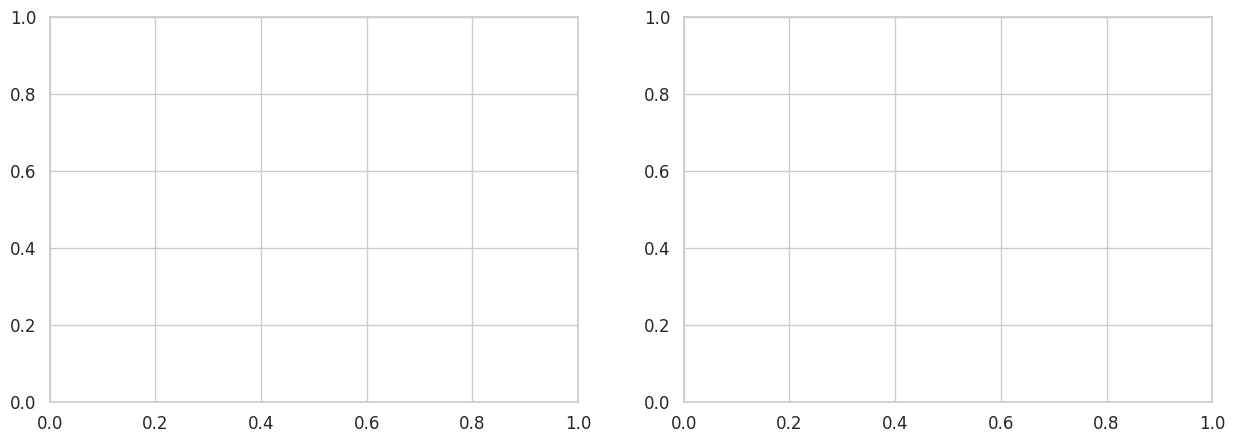

In [45]:
# choose data
day = "2020-06-07"
inverter1 = "2"
inverter2 = "22"
df_pred = df_plant1[(df_plant1["DATE_STR"] == day)].copy()

fig, axes = plt.subplots(1, 2)

sns.lineplot(df_pred.DATE_TIME,df_pred[df_pred["SENSOR_NAME"] == inverter1].DC_POWER, label="Measured DC", color="b", ax=axes[0])
sns.lineplot(df_pred.DATE_TIME,df_pred[df_pred["SENSOR_NAME"] == inverter1].Residual, label="Residual", color="g", ax=axes[0])
sns.lineplot(df_pred.DATE_TIME,df_pred[df_pred["SENSOR_NAME"] == inverter1].Prediction, label="Predicted DC", color="r", ax=axes[0])

sns.lineplot(df_pred.DATE_TIME,df_pred[df_pred["SENSOR_NAME"] == inverter2].DC_POWER, label="Measured DC", color="b", ax=axes[1])
sns.lineplot(df_pred.DATE_TIME,df_pred[df_pred["SENSOR_NAME"] == inverter2].Residual, label="Residual", color="g", ax=axes[1])
sns.lineplot(df_pred.DATE_TIME,df_pred[df_pred["SENSOR_NAME"] == inverter2].Prediction, label="Predicted DC", color="r", ax=axes[1])

plt.gcf().axes[0].xaxis.set_major_formatter(xformatter) # set xaxis format
plt.gcf().axes[1].xaxis.set_major_formatter(xformatter) # set xaxis format
axes[0].set_xlabel("Time")
axes[1].set_xlabel("Time")
axes[0].set_ylabel("DC Power (kW)")
axes[1].set_ylabel("")
axes[1].set_ylim(-2500, 14000)
axes[0].set_title("Example: Normal Operation")
axes[1].set_title("Example: Fault Detected")
plt.show()

In [ ]:
inverter2= "22"
df_pred2 = df_plant1[df_plant1["SENSOR_NAME"]==inverter2].copy()
sns.lineplot(df_pred2.DATE_TIME,df_pred2.Prediction, label="Predicted DC", color="r")
sns.lineplot(df_pred2.DATE_TIME,df_pred2.DC_POWER, label="Measured DC", color="b")
sns.lineplot(df_pred2.DATE_TIME,df_pred2.Residual-5000, label="Residual (Offset)", color="g")
plt.xlabel("Date")
plt.ylabel("Power (kW)")
plt.title("Fault Detection: Inverter 22")
plt.show()

### 4.2.1 Nonlinear Model

According to [Hooda et al. (2018)](https://www.researchgate.net/publication/309399733_PV_Power_Predictors_for_Condition_Monitoring) the generated power of a photovoltaic cell can be modeled by the nonlinear equation
\begin{equation}
    P(t) = a E(t) \left(1-b (T(t) + \frac{E(t)}{800} (c-20) - 25) - d \ln(E(t))\right)
\end{equation}
with irradiance $E(t)$, Temperature $T(t)$ and coefficients $a,b,c,d$.

In [ ]:
def func(X, a, b, c, d):
    '''Nonlinear function to predict DC power output from Irradiation and Temperature.'''
    x,y = X
    x=x*1000
    y=y*1000
    return a*x*(1-b*(y+x/800*(c-20)-25)-d*np.log(x+1e-10))

# fit function
p0 = [1.,0.,-1.e4,-1.e-1] # starting values
popt, pcov = curve_fit(func, (df_train.IRRADIATION, df_train.MODULE_TEMPERATURE), df_train.DC_POWER, p0, maxfev=5000)
sigma_abcd = np.sqrt(np.diagonal(pcov))

# predict & save
df_train["Prediction_NL"] = func((df_train.IRRADIATION, df_train.MODULE_TEMPERATURE), *popt)
df_train["Residual_NL"] = df_train["Prediction_NL"] - df_train["DC_POWER"]

df_plant1["Prediction_NL"] = func((df_plant1.IRRADIATION, df_plant1.MODULE_TEMPERATURE), *popt)
df_plant1["Residual_NL"] = df_plant1["Prediction_NL"] - df_plant1["DC_POWER"]

In [ ]:
plt.scatter(df_plant1.IRRADIATION, df_plant1.DC_POWER, label="Measured")
plt.scatter(df_plant1.IRRADIATION, df_plant1.Prediction_NL, color="r", label="NL Prediction")
plt.legend()
plt.xlabel("Irradiation (kW/m²)")
plt.ylabel("DC Power (kW)")
plt.title("Nonlinear Model Prediction")
plt.show()

In [ ]:
# choose data
day = "2020-06-07"
inverter1 = "2"
inverter2 = "22"
df_pred = df_plant1[(df_plant1["DATE_STR"] == day)].copy()

fig, axes = plt.subplots(1, 2)

sns.lineplot(df_pred.DATE_TIME,df_pred[df_pred["SENSOR_NAME"] == inverter1].DC_POWER, label="Measured DC", color="b", ax=axes[0])
sns.lineplot(df_pred.DATE_TIME,df_pred[df_pred["SENSOR_NAME"] == inverter1].Residual_NL, label="NL Residual", color="g", ax=axes[0])
sns.lineplot(df_pred.DATE_TIME,df_pred[df_pred["SENSOR_NAME"] == inverter1].Prediction_NL, label="NL Predicted DC", color="r", ax=axes[0])

sns.lineplot(df_pred.DATE_TIME,df_pred[df_pred["SENSOR_NAME"] == inverter2].DC_POWER, label="Measured DC", color="b", ax=axes[1])
sns.lineplot(df_pred.DATE_TIME,df_pred[df_pred["SENSOR_NAME"] == inverter2].Residual_NL, label="NL Residual", color="g", ax=axes[1])
sns.lineplot(df_pred.DATE_TIME,df_pred[df_pred["SENSOR_NAME"] == inverter2].Prediction_NL, label="NL Predicted DC", color="r", ax=axes[1])

plt.gcf().axes[0].xaxis.set_major_formatter(xformatter) # set xaxis format
plt.gcf().axes[1].xaxis.set_major_formatter(xformatter) # set xaxis format
axes[0].set_xlabel("Time")
axes[1].set_xlabel("Time")
axes[0].set_ylabel("DC Power (kW)")
axes[1].set_ylabel("")
axes[0].set_ylim(-3000, 14000)
axes[1].set_ylim(-3000, 14000)
axes[0].set_title("Example: Normal Operation")
axes[1].set_title("Example: Fault Detected")
plt.show()

In [ ]:
inverter2= "1"
df_pred2 = df_plant1[df_plant1["SENSOR_NAME"]==inverter2].copy()
sns.lineplot(df_pred2.DATE_TIME,df_pred2.Prediction_NL, label="NL Prediction", color="r")
sns.lineplot(df_pred2.DATE_TIME,df_pred2.DC_POWER, label="Measured DC", color="b")
sns.lineplot(df_pred2.DATE_TIME,df_pred2.Residual_NL-5000, label="NL Residual (Offset)", color="g")
plt.xlabel("Date")
plt.ylabel("Power (kW)")
plt.title("Fault Detection Example: Inverter {}".format(inverter2))
plt.show()

In [ ]:
inverter2= "22"
df_pred2 = df_plant1[df_plant1["SENSOR_NAME"]==inverter2].copy()
sns.lineplot(df_pred2.DATE_TIME,df_pred2.Prediction_NL, label="NL Prediction", color="r")
sns.lineplot(df_pred2.DATE_TIME,df_pred2.DC_POWER, label="Measured DC", color="b")
sns.lineplot(df_pred2.DATE_TIME,df_pred2.Residual_NL-5000, label="NL Residual (Offset)", color="g")
plt.xlabel("Date")
plt.ylabel("Power (kW)")
plt.title("Fault Detection Example: Inverter {}".format(inverter2))
plt.show()

### 4.2.3 Model Comparison

To compare the two models we can take a look at their respective residuals. The nonlinear model seems to perform slightly better than the linear model, especially at times of high irradiance.

In [ ]:
# plot model comparison residual
plt.figure(figsize=(5,5))
sns.scatterplot(df_train.Prediction, df_train.Residual, color="b", label="LI Residual")
sns.scatterplot(df_train.Prediction_NL, df_train.Residual_NL, color="r", label="NL Residual")
axes = plt.gca()
plt.ylabel("Residual")
plt.xlabel("Predicted DC Power")
plt.title("Model Comparison")
plt.show()

# 4.2.4 NL Fault Detection

Let's now use the irradiance and temperature data to predict the expected DC power with the nonlinear model. This allows us to identify addtional anomalies by comparing the measured DC power with the prediction. The additional anomalies indicate equipment underperformance or need for maintenance.


In [ ]:
# set confidence range for residual for fault
limit_fault=4000

# Create new column to check proper operation
# Return "Normal" if operation is normal and "Fault" if operation is faulty
df_plant1["STATUS_NL"] = 0
for index in df_plant1.index:
    if  df_plant1["Residual_NL"][index] > limit_fault:
        df_plant1["STATUS_NL"][index] = "Fault"  
    else:
        df_plant1["STATUS_NL"][index] = "Normal"

In [ ]:
fig=px.bar(df_plant1[df_plant1["STATUS_NL"]== "Fault"]["DATE"].value_counts(), title="Faults: Nonlinear Model", labels={"value":"Faults", "index":"Date", "SENSOR_NAME":"Inverter"}, )
fig.update(layout_showlegend=False)

In [ ]:
fig=px.bar(df_plant1[df_plant1["STATUS_NL"]== "Fault"]["SOURCE_KEY"].value_counts(), title="Underperformance & Faults: Nonlinear Model", labels={"value":"Faults", "index":"Inverter", "SENSOR_NAME":"Inverter"})
fig.update(layout_showlegend=False)

In [ ]:
fig = px.scatter(df_plant1, x="DATE_TIME", y="DC_POWER", title="Underperformance & Faults: Nonlinear Model (Zoomed in)", color="STATUS_NL", labels={"DC_POWER":"DC Power (kW)", "DATE_TIME":"Date Time", "STATUS_NL":"Status"},range_x=[datetime.date(2020, 6, 1), datetime.date(2020, 6, 17)])
fig.update_traces(marker=dict(size=3, opacity=0.7), selector=dict(mode='marker'))
fig.show()

In [ ]:
print("The most anomalies were recorded on {} and {}." .format(df_plant1[df_plant1["STATUS_NL"]== "Fault"]["DATE"].value_counts().index[0], df_plant1[df_plant1["STATUS_NL"]== "Fault"]["DATE"].value_counts().index[1]))
print("Inverter {} and {} had the most events of failure/underperformance." .format(df_plant1[df_plant1["STATUS_NL"]== "Fault"]["SOURCE_KEY"].value_counts().index[0],df_plant1[df_plant1["STATUS_NL"]== "Fault"]["SOURCE_KEY"].value_counts().index[1]))

<a id="section-five"></a>
# 5. Summary

* **EDA:** Noticed some potential issues with the data: DAILY_YIELD is decreasing on some days even though this should not be possible by definition. Inverters have different number of data points

* **Challenge 1:** Even though this notebook did not focus on forecasting, the power-irradiance models may be helpful in combination with external data from local weather forecasts to predict the generated power for the next couple days.

* **Challenge 2&3:** Successfully identified **events of equipment failure and underperformance** with a rule-based method and linear/nonlinear modeling of the relationship between irradiance, temperature and DC power. This approach can be useful for real-time condition monitoring and fault detection.

### Thank you for reading and please upvote this notebook if you found it useful!